In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [20]:
# 导入数据集
data = pd.read_csv('creditcard.csv')
data.head()

# v1 -  v28 也没有具体说这些列表达什么含义，对这些数据都做了一部分处理 
# 通过PC的降维操作，进行特征的压缩，相当于这些特征都是直接用的特征
# Amount 表示交易的金额
# Class 等于0，表示正样本， Clsss等于1 表示负样本

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64


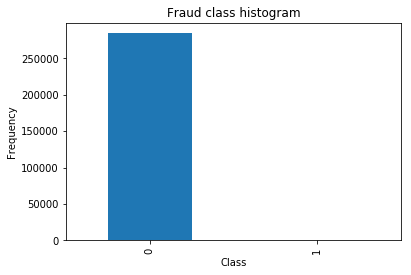

In [21]:
# 首先明确，我们拿到数据后，需要做什么事情？
# 这里是需要做欺诈检测这个事情，也就是说，我们知道数据里面，存在着正常的数据和异常的信息
# 也就是我们需要对信用卡交易信息，进行二分类问题，分成正常交易信息和异常交易信息
# 可能这里大部分数据都是正的样本，只有极少部分是负样本

# value_counts是为了查看这里有多少不重复的数据值的个数
count_classes = pd.value_counts(data['Class'], sort= True).sort_index()
count_classes.plot(kind = 'bar')
plt.title('Fraud class histogram')  # 欺诈类直方图
plt.xlabel('Class')
plt.ylabel('Frequency')
print(count_classes)

# 下图可以知道，  正样本大概有30W，负样本只有500
# 也就是它是一个样本极度不规则的数据，我们需要提出怎么解决方案呢？
# 需要用到  过采样  和 下采样
#
#  下采样：对于不均衡数据，我们采用下采样，就是把多的数据取出一部分，将它变成 两个样本数据相差差不多
#  过采样：对于较少的数据，我们采用生成虚拟数据，他们也是负样本，这样两个数据也类似了

#  综上： 下采样：就是让数据一样少，  过采样：就是让数据一样多

In [22]:
# 使用Scikit-learn数据预处理操作
from sklearn.preprocessing import StandardScaler 

# 因为Amonut数值的差异比较大，所以我们要保证 他们数值之间分布差异差不多
# 也就是要对他们做归一化处理 和 标准化操作
# fit_transform: 是数据做一个变换，  需要将data['Amount']数据，变成 -1,1之间， 最后做成一个新的特征
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
# 把Time，和原来的Amonut特征，都删除掉， axis表示删除一列
data = data.drop(['Time', 'Amount'], axis=1)
data.head()

array([[ 0.24496426],
       [-0.34247454],
       [ 1.16068593],
       ...,
       [-0.0818393 ],
       [-0.31324853],
       [ 0.51435531]])

In [25]:
###### 下面我们采用下采样进行处理(也就是说，让正负样本数一样少) ###############

# 首先我们对数据进行切分，把数据变成特征数据和预测数据

# 把所有数据取出来，同时不包括 Class这个列, 这样就构成了特征数据
X = data.loc[:, data.columns != 'Class']

# 把Class这一列取出来， 这样就构成了label值
y = data.loc[:, data.columns == 'Class']

# 计算 Class = 1 的样本有多少个
number_records_fraud = len(data[data.Class == 1])
# 我们把这些样本都取出来，通过index来取数据
fraud_indices= np.array(data[data.Class ==1].index)


#### 我们需要在正样本中进行随机选择 ###

# 首先把等于0的索引都取值出来
normal_indices = data[data.Class == 0].index

# 使用numpy的 choise随机选择， 需要传入 选择数据，选择的个数， replace:表示是否代替
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace= False)
# 将选择出来的数据，变成np数组
random_normal_indices = np.array(random_normal_indices)

# 将 负样本数据 和 随机选择的正样本数据，进行合并操作
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

under_sample_data = data.iloc[under_sample_indices, :]

# 变成测试数据 和 标签数据
X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']


In [33]:
####  交叉验证 #######

# 从train中选择出一部分作为训练集和测试集
from sklearn.cross_validation import train_test_split

# 对数据集进行切分   random_state：表示随机切分状态为0，以后每次随机的数都能复现
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("训练数据集长度", len(X_train))
print("测试数据集长度", len(X_test))
print("训练样本总数", len(X_train) + len(X_test))

# 对900多个采样数据集进行切分
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample,
                                                                                                    test_size=0.3, random_state = 0)
print("---")
print("下采样训练数据集长度", len(X_train_undersample))
print("下采样测试数据集长度", len(X_test_undersample))
print("下采样训练样本总数", len(X_train_undersample) + len(X_test_undersample))

# 我们以后需要使用原始的 85443个测试数据集，进行测试操作



训练数据集长度 199364
测试数据集长度 85443
训练样本总数 284807
---
下采样训练数据集长度 688
下采样测试数据集长度 296
下采样训练样本总数 984


In [ ]:
#### 模型评估标准 ####
#  使用 Recall 召回率，查全率进行衡量   Recall = TP / (TP + FN)
#  在检测任务的时候，是使用Recal当成评估标准

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, classification_report
